In [146]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from skimage import io
from skimage.transform import resize
import h5py
from skimage import color

In [147]:
def qpie_encoding(image_data):
    n = int(np.log2(image_data.size))

    amplitudes = image_data.flatten()
    amplitudes = amplitudes/np.linalg.norm(amplitudes) #normalize coefficients
    return amplitudes, n

10


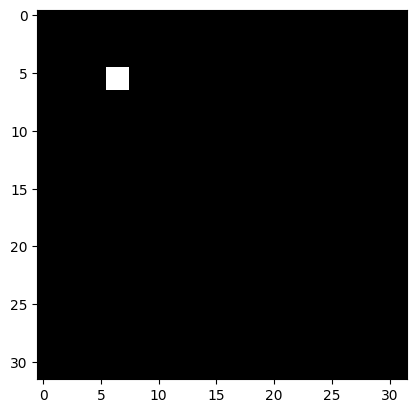

In [148]:
img = np.zeros((32,32))
img[5,6] = 1
img[6,6] = 1
img[5,7] = 1
img[6,7] = 1
plt.imshow(img,cmap='gray')

amp, n = qpie_encoding(img)
print(n)
SHOTS = 1048576
dev1 = qml.device('default.qubit', wires=n, shots=SHOTS)

In [149]:

def circuit(init_value, num_wire, device):
    def inside_circuit():
        qml.QubitStateVector(init_value, wires=range(num_wire))
        return qml.probs()
    return qml.QNode(inside_circuit, device)

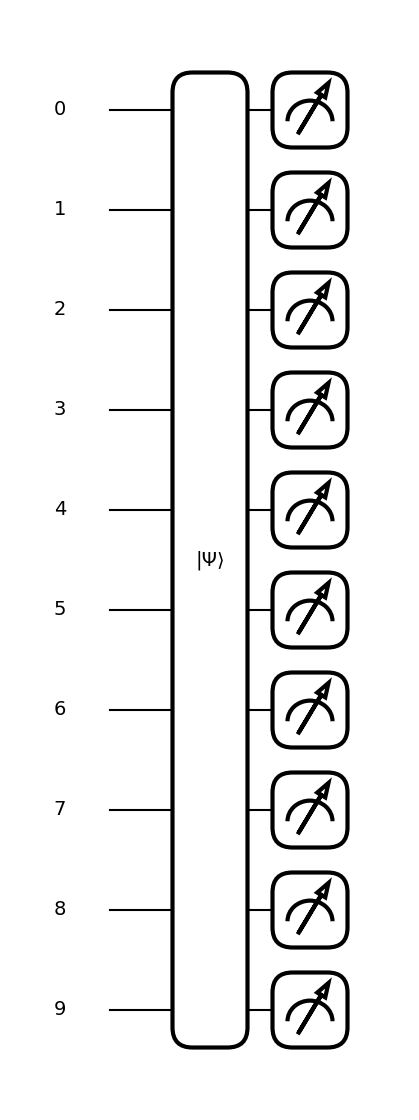

In [150]:
fig, ax = qml.draw_mpl(circuit(amp,n,dev1))()

In [151]:
measured_circuit = circuit(amp,n,dev1)()

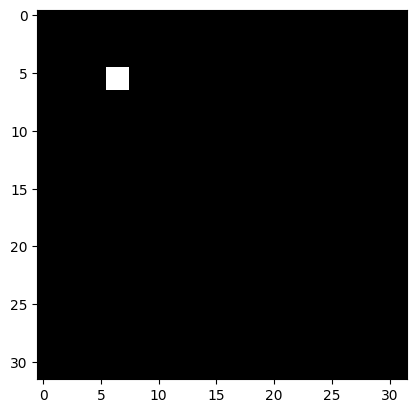

In [152]:
norm = (np.linalg.norm(img.flatten()))
imout = measured_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

In [153]:
def MSE(img1,img2):

    img = (img1-img2)**2
    s = np.sum(img.flatten())/(len(img1**2))

    return s

In [154]:
MSE(img,imout)

0.07031251169109964

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]
[4.03451902 3.97993012 3.89310288 ... 3.74635239 3.8497159  3.95136448]


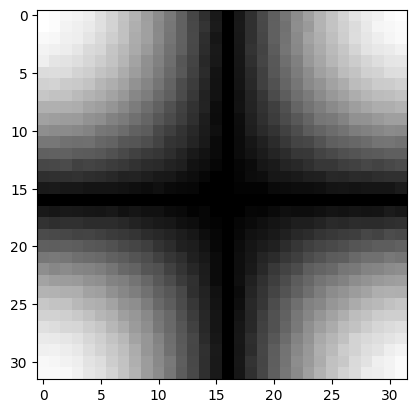

In [155]:
def qft_circuit(init_value,num_wire,device):
    @qml.qnode(device)
    def inside_circuit():
        qml.QubitStateVector(init_value, wires=range(num_wire))
        print(num_wire)
        print(f"muh wires : {[i for i in range(int(num_wire/2))]}")
        print(f"meh wires : {[i+int(num_wire/2) for i in range(int(num_wire/2))]}")
        qml.QFT(wires=[i for i in range(int(num_wire/2))])
        qml.QFT(wires=[i+int(num_wire/2) for i in range(int(num_wire/2))])
        return qml.probs()
    return qml.QNode(inside_circuit, device)

measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev1)()) * norm * 2**(n/2)
print(measured_qft_circuit)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]


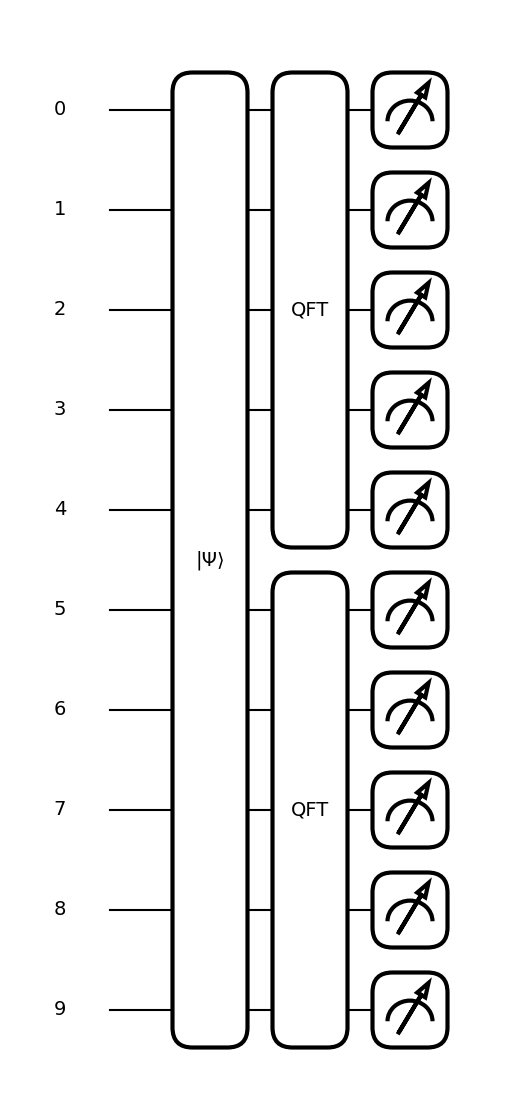

In [156]:
fig, ax = qml.draw_mpl(qft_circuit(amp,n,dev1))()

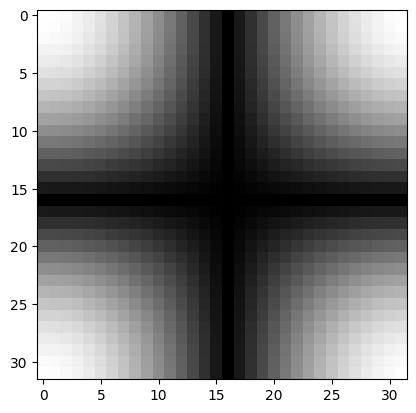

In [157]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [158]:
MSE(imout,np.abs(ft))

0.030679370455904475

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]


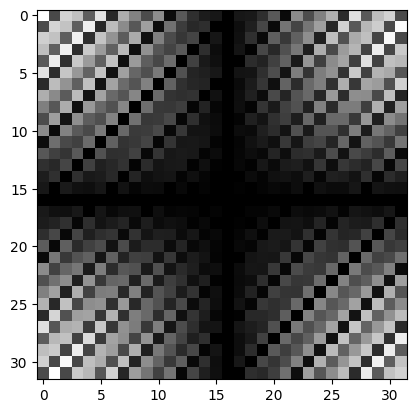

In [159]:
img = np.zeros((32,32))
img[5,6] = 1
img[6,6] = 1
img[5,7] = 1
img[6,7] = 1
img[24,25] = 1
img[25,25] = 1
img[24,26] = 1
img[25,26] = 1
amp, n = qpie_encoding(img)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev1)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

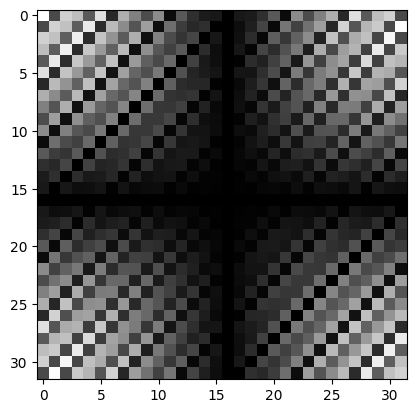

In [160]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [161]:
MSE(imout,np.abs(ft))

0.06385479659724938

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]


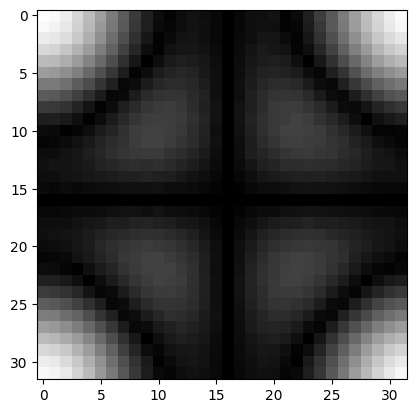

In [162]:
img = np.zeros((32,32))
img[4,4]=1
img[4,5]=1
img[5,4]=1
img[5,5]=1
img[6,4]=1
img[6,5]=1
img[7,4]=1
img[7,5]=1
img[5,3]=1
img[6,3]=1
img[5,5]=1
img[6,6]=1
img[5,6]=1
amp, n = qpie_encoding(img)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev1)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

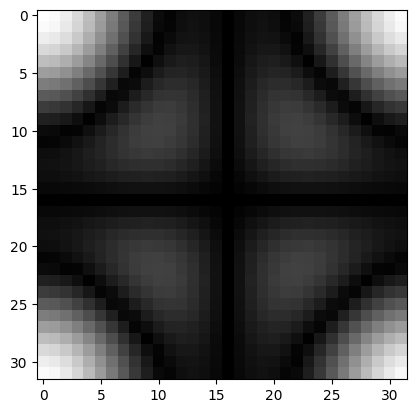

In [163]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [164]:
MSE(imout,np.abs(ft))

0.09277887393839265

12
12
muh wires : [0, 1, 2, 3, 4, 5]
meh wires : [6, 7, 8, 9, 10, 11]


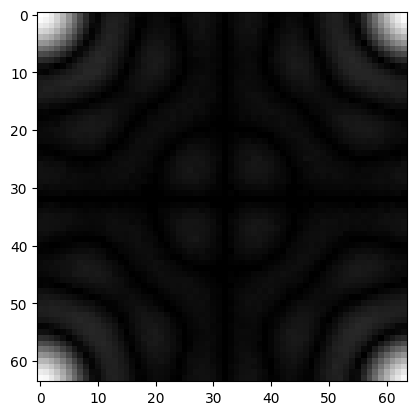

In [169]:
img = np.zeros((64,64))
img[10:14,10:18] =1
img[9,11:17]=1
img[8,12:16]=1
img[14,11:17]=1
img[15,12:16]=1
amp, n = qpie_encoding(img)
print(n)
dev2 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev2)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

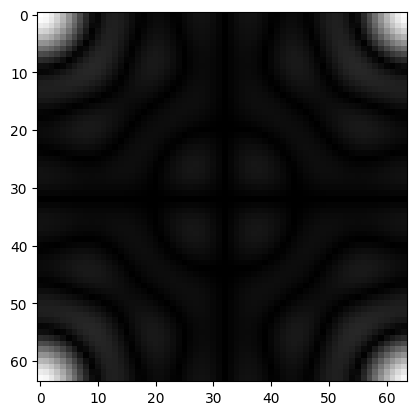

In [171]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [174]:
MSE(imout,np.abs(ft))

3.304504200984254

16


215155007633.78802

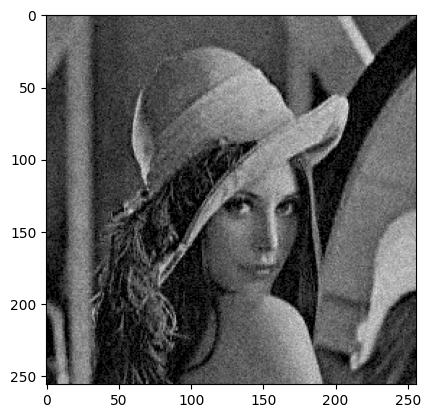

In [200]:
img = io.imread('lena.jpg', as_gray=True)
im = resize(img,(256,256))
amp, n = qpie_encoding(img)
print(n)
dev3 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = circuit(amp,n,dev3)()
imout = measured_qft_circuit.reshape(img.shape)

plt.figure()
plt.imshow(imout,cmap='gray')
MSE(imout,im)

16


50.48537443330441

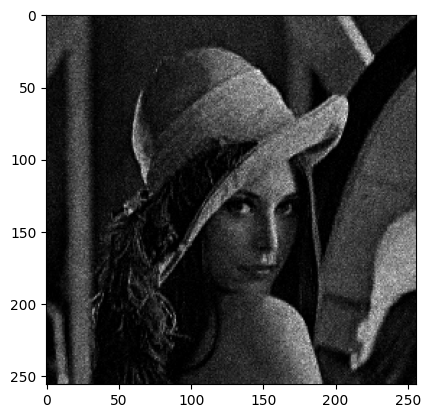

In [199]:

amp, n = qpie_encoding(img)
print(n)
dev3 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = circuit(amp,n,dev3)()
imout = measured_qft_circuit.reshape(img.shape)
plt.figure()
plt.imshow(imout,cmap='gray')

MSE(imout,im)

16
16
muh wires : [0, 1, 2, 3, 4, 5, 6, 7]
meh wires : [8, 9, 10, 11, 12, 13, 14, 15]


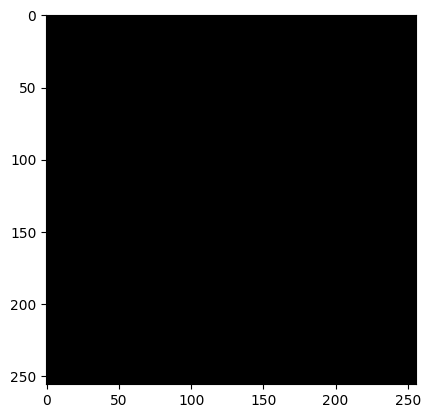

In [202]:
amp, n = qpie_encoding(img)
print(n)
dev4 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = qft_circuit(amp,n,dev4)()
imout = measured_qft_circuit.reshape(img.shape)
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray')